## Part 4: Network analysis

### 4.1 Centrality meassures
Degree centrality (fraction of nodes it is connected to ).
Out-degree centrality (fraction of nodes its outgoing edges are connected to).
In-degree centrality (fraction of nodes its incoming edges are connected to).
Betweenes Centrality (sum of the fraction of all-pairs shortest paths that pass through).
Closseness Centrality meassure (reciprocal of the average shortest path distance to u over all n-1 reachable nodes)

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
# import numpy as np
# import math
# from operator import itemgetter
# from pyvis.network import Network as net

# import ipywidgets as widgets
# from ipywidgets import interact, interactive, fixed, interact_manual,  HBox, VBox
# from IPython.display import display, HTML

# from utils.ui_functions import alert_user, StopExecution, make_download_button
# from utils.conf import my_style, my_layout
from utils.functions import truncate

# alert_user = lambda message: display(HTML(alert(message)))

In [2]:
sfw_matrix = pd.read_pickle('results/sfw_matrix.pickle')
trophic_levels = pd.read_pickle('results/trophic_levels.pickle')
G = nx.read_gpickle('results/G.pickle')

In [3]:
from utils.ui_functions import make_download_button

df_measures = pd.DataFrame.from_dict({"degree centrality": nx.degree_centrality(G),
                                      "out-degree centrality": nx.out_degree_centrality(G),
                                      "in-degree centrality": nx.in_degree_centrality(G),
                                      "betweenness centrality": nx.betweenness_centrality(G),
                                      "closeness centrality": nx.closeness_centrality(G)})
df_measures.index.name = 'trophic group'
display(make_download_button('centrality_measures.csv', raw_contents=df_measures.to_csv()))

HTML(value='<html>\n<head>\n<meta name="viewport" content="width=device-width, initial-scale=1">\n</head>\n<bo…

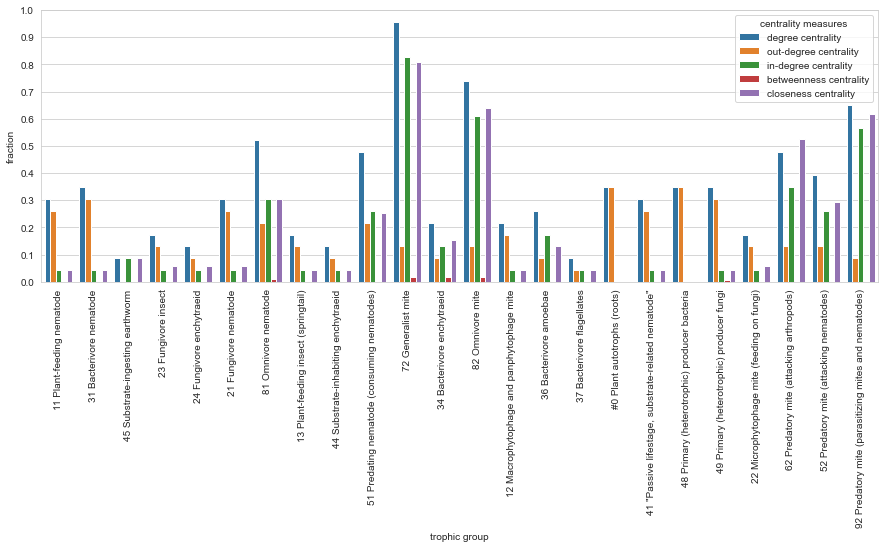

In [11]:
# to long format
df_meassures_melt = df_measures.reset_index()
df_meassures_melt = df_meassures_melt.melt("trophic group", var_name='centrality measures', value_name='fraction')

sns.set_style("whitegrid")
fig, plot = plt.subplots(figsize=(15, 5))
ax = sns.barplot(y="fraction", x="trophic group", hue='centrality measures', data=df_meassures_melt)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_yticks(np.arange(0,1.1,0.1))
_ = ax.set_ylim(0,1)
# _ = ax.set_title("Summary of network centrality measures")
# _ = ax.set_xticklabels([truncate(s, 25) for s in df_measures.index])

In [5]:
# To-Do: ask Christian if ratio of in/out-degre would be useful?

### 4.2 Network complexity and connectance

Complexity as the average number of links per species (*Christian needs to confirm and which one to use?)

In [6]:
# Ask Christian if we keep his complexity? Its similar to density above.

In [7]:
# Christian complexity
Chr_complex = G.number_of_edges() * G.number_of_nodes()

# Complexity (average number of links per species (Wikipedia())
from statistics import mean
def complexity(g):
    """Calculates the average number of edges (degree) per node in a graph g"""
    deg = g.degree()
    deg_ls = []
    for n, d in deg:
        deg_ls.append(d)
    
    return mean(deg_ls) 

# Connectance
connectance = G.number_of_edges() / (G.number_of_nodes())**2

print(f"Complexity: {complexity(G)}")
print(f"Connectance: {connectance}") 

Complexity: 7.833333333333333
Connectance: 0.16319444444444445
